In [1]:
import torch
import torchvision
import gc
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

2024-10-08 14:03:59.911899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 14:03:59.926058: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 14:03:59.930548: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 14:03:59.941742: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using device: cuda
[INFO] Current device: NVIDIA GeForce RTX 2080 Ti , device num:0


Input shape: torch.Size([4, 1, 28, 28])
Labels: tensor([1, 5, 9, 7])


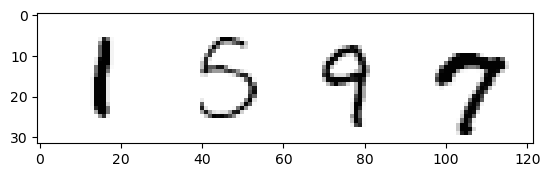

In [2]:
batch = 4
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)
train_dataloader = DataLoader(dataset, batch_size=batch, shuffle=True)
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
#imshow 显示前对图像数据进行适当的归一化或剪裁（确保数据在 [0, 1] 的范围内）。
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

In [3]:
def corrupt(x, amount, timestep):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
    #print(amount)
    amount_map = amount / timestep 
    output = x * (1 - amount_map) + noise * amount_map
    #print(x)
    #print(output)
    return output, noise

In [4]:
'''
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].detach().cpu(), cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1000, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount,1000)

# Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].detach().cpu(), cmap="Greys")
'''

'\n# Plotting the input data\nfig, axs = plt.subplots(2, 1, figsize=(12, 5))\naxs[0].set_title("Input data")\naxs[0].imshow(torchvision.utils.make_grid(x)[0].detach().cpu(), cmap="Greys")\n\n# Adding noise\namount = torch.linspace(0, 1000, x.shape[0])  # Left to right -> more corruption\nnoised_x = corrupt(x, amount,1000)\n\n# Plotting the noised version\naxs[1].set_title("Corrupted data (-- amount increases -->)")\naxs[1].imshow(torchvision.utils.make_grid(noised_x)[0].detach().cpu(), cmap="Greys")\n'

In [5]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )
        self.act = nn.SiLU()  # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))  # Through the layer and the activation function
            if i < 2:  # For all but the third (final) down layer:
                h.append(x)  # Storing output for skip connection
                x = self.downscale(x)  # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upscale
                x += h.pop()  # Fetching stored output (skip connection)
            x = self.act(l(x))  # Through the layer and the activation function

        return x

Finished epoch 4. Average loss for this epoch: 0.013945


(0.0, 0.1)

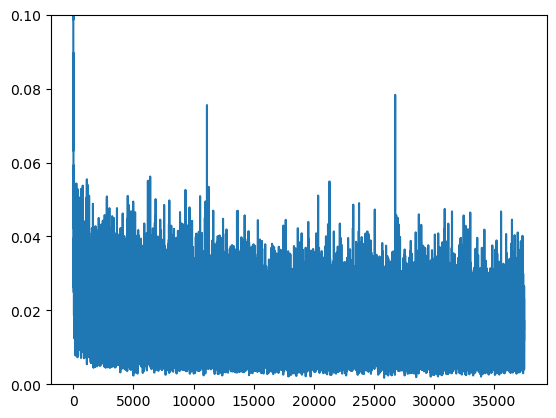

In [12]:
# Dataloader (you can mess with batch size)
batch_size = 8
timestep = 1000
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 5

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:
        clear_output(wait=True)

        # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        #randint(0, timesteps, (batch_size,), device=device)
        noise_amount = torch.randint(0, timestep, (x.shape[0],)).to(device)  # Pick random noise amounts
        noisy_x , noise = corrupt(x, noise_amount, timestep)  # Create our noisy x

        # Get the model prediction
        # kind is try to pred the denoised_image directly
        pred = net(noisy_x)
        # Calculate the loss
        #if pred the modle there use lots of time
        #loss = loss_fn(pred, noise)  # How close is the output to the true 'clean' x?
        loss = loss_fn(pred, x) 

        # Backprop and update the params:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss for later
        losses.append(loss.item())
        '''
        del noisy_x, loss, pred
        torch.cuda.empty_cache()
        gc.collect()
        
        plt.close()
        '''
        

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

In [7]:
def denoise(noisy_img, predicted_noise, amount, timestep):
    """
    Denoise the input `noisy_img` by removing the `predicted_noise`
    according to the `amount` and `timestep`.
    """
    # 调整amount的形状，使其可以广播
    amount = amount.view(-1, 1, 1, 1)

    # 计算去噪的权重，与`corrupt`函数中的相反
    amount_map = amount / timestep
    amount_map = torch.clamp(amount_map, min=1e-5)  # 避免数值问题

    # 使用公式去噪
    denoised_img = (noisy_img - predicted_noise * amount_map) / (1 - amount_map)

    return denoised_img

tensor([ 68, 421, 951, 869, 450, 989,  15,  72], device='cuda:0')


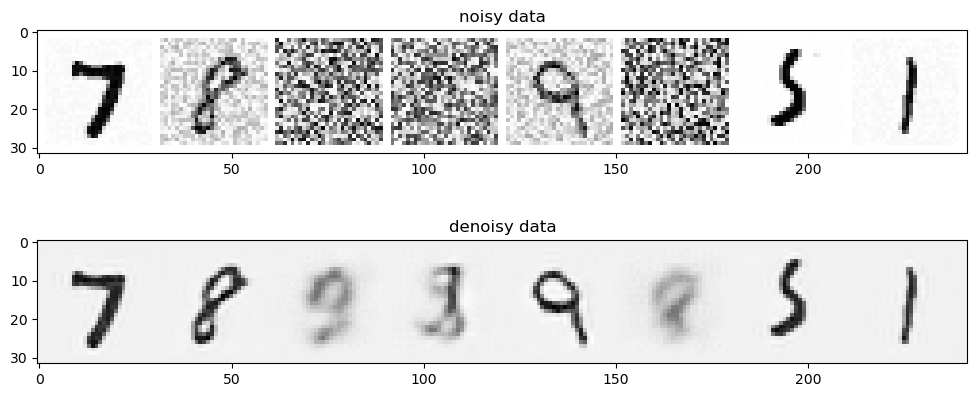

In [14]:
# 生成图像
net.eval()
with torch.no_grad():
    #sample_batch : a batch of images
    sample_batch = next(iter(train_dataloader))[0].to(device)
    batch_size = sample_batch.size(0)
    t = torch.randint(0, timestep, (batch_size,), device=device)
    print(t)
    #t = t.view(-1, 1, 1, 1)
    noisy_img , noise= corrupt(sample_batch, t, timestep)
    denoised_img = net(noisy_img)
    #pre_noised = net(noisy_img)
    #denoised_img = denoise(noisy_img,pre_noised,t,timestep)

    fig, axs = plt.subplots(2, 1, figsize=(12, 5))
    axs[0].set_title("noisy data")
    axs[0].imshow(torchvision.utils.make_grid(noisy_img)[0].detach().cpu(), cmap="Greys")
    '''
    axs[1].set_title("pre_noisy data")
    axs[1].imshow(torchvision.utils.make_grid(pre_noised)[0].detach().cpu(), cmap="Greys")
    '''
    axs[1].set_title("denoisy data")
    axs[1].imshow(torchvision.utils.make_grid(denoised_img)[0].detach().cpu(), cmap="Greys")

Finished epoch 4. Average loss for this epoch: 0.009420


(0.0, 0.1)

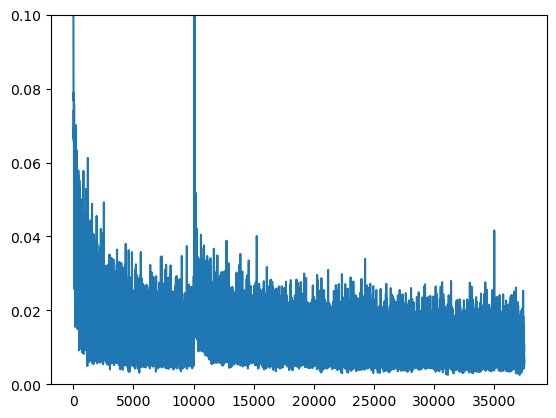

In [15]:
# Dataloader (you can mess with batch size)
batch_size = 8
timestep = 1000
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 5

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:
        clear_output(wait=True)

        # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        #randint(0, timesteps, (batch_size,), device=device)
        noise_amount = torch.randint(0, timestep, (x.shape[0],)).to(device)  # Pick random noise amounts
        noisy_x , noise = corrupt(x, noise_amount, timestep)  # Create our noisy x

        # Get the model prediction
        # kind is try to pred the denoised_image directly
        pred = net(noisy_x)
        # Calculate the loss
        #if pred the modle there use lots of time
        loss = loss_fn(pred, noise)  # How close is the output to the true 'clean' x?
        #loss = loss_fn(pred, x) 

        # Backprop and update the params:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss for later
        losses.append(loss.item())
        '''
        del noisy_x, loss, pred
        torch.cuda.empty_cache()
        gc.collect()
        
        plt.close()
        '''
        

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

tensor([313,  81, 707, 720, 190, 272, 335, 338], device='cuda:0')


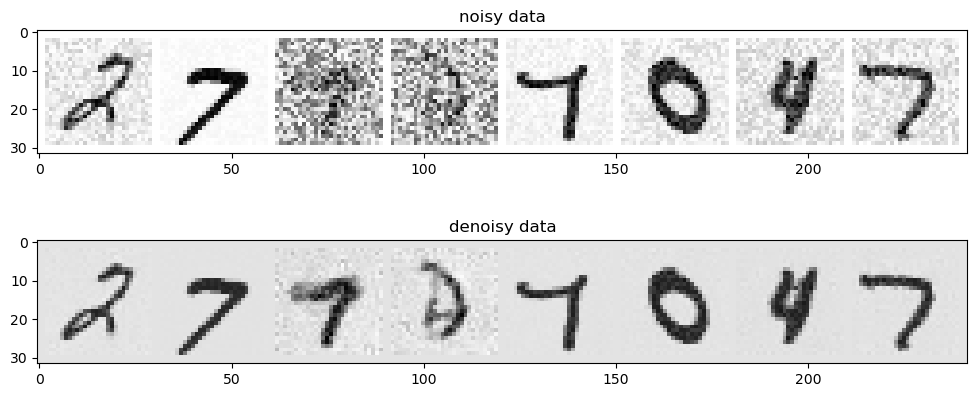

In [17]:
# 生成图像
net.eval()
with torch.no_grad():
    #sample_batch : a batch of images
    sample_batch = next(iter(train_dataloader))[0].to(device)
    batch_size = sample_batch.size(0)
    t = torch.randint(0, timestep, (batch_size,), device=device)
    print(t)
    #t = t.view(-1, 1, 1, 1)
    noisy_img , noise= corrupt(sample_batch, t, timestep)
    #denoised_img = net(noisy_img)
    pre_noised = net(noisy_img)
    denoised_img = denoise(noisy_img,pre_noised,t,timestep)

    fig, axs = plt.subplots(2, 1, figsize=(12, 5))
    axs[0].set_title("noisy data")
    axs[0].imshow(torchvision.utils.make_grid(noisy_img)[0].detach().cpu(), cmap="Greys")
    
    axs[1].set_title("pre_noisy data")
    axs[1].imshow(torchvision.utils.make_grid(pre_noised)[0].detach().cpu(), cmap="Greys")
    
    axs[1].set_title("denoisy data")
    axs[1].imshow(torchvision.utils.make_grid(denoised_img)[0].detach().cpu(), cmap="Greys")